# Deep Learning &mdash; Assignment 2

Second assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Implement a neural network in PyTorch;
2. Use automatic differentiation to compute gradients;
3. Experiment with SGD and Adam;
4. Experiment with hyperparameter optimization;
5. Experiment with regularization techniques.

Before we start, if PyTorch or pandas is not installed, install it now with `pip install`.

In [ ]:
# !pip install torch
# !pip install torchvision
# !pip install pandas

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import torch
import time
import torchvision
import tqdm.notebook as tqdm
import collections
import IPython
import pandas as pd

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

# Fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

## 2.1 Implementing a model with PyTorch

In the first assignment, you implemented a neural network from scratch in NumPy. In practice, it is more convenient to use a deep learning framework. In this course, we use [PyTorch](https://pytorch.org/).

In this example, we will use PyTorch to implement and train a simple neural network.

### PyTorch tensors

Similar to NumPy, PyTorch works with multi-dimensional tensors. These can be scalars, vectors, matrices, or have an even higher dimension.

Tensors can be created by converting NumPy arrays, or directly in PyTorch:

In [2]:
# create a 10x10 matrix filled with zeros
x = np.zeros([10, 10])
x = torch.tensor(x)
print(x)

# create a 3x5 matrix of ones
x = torch.ones([3, 5])
print(x)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


Note that the tensors have a datatype (`dtype`) that defines the type of number in the matrix. This can be 32-bit or 64-bit floating point numbers, or various types of integers. (See the [PyTorch documentation](https://pytorch.org/docs/stable/tensor_attributes.html#torch.dtype) for a complete list.)

In [3]:
print('float32:', torch.tensor([1., 2., 3.], dtype=torch.float32))
print('float64:', torch.tensor([1., 2., 3.], dtype=torch.float64))
print('int:', torch.tensor([1, 2, 3], dtype=torch.int))
print('long:', torch.tensor([1, 2, 3], dtype=torch.long))

float32: tensor([1., 2., 3.])
float64: tensor([1., 2., 3.], dtype=torch.float64)
int: tensor([1, 2, 3], dtype=torch.int32)
long: tensor([1, 2, 3])


It can be important to choose the correct datatype for your tensors, because this influences the precision, the computational cost, or the memory requirements. Some functions also specifically require integers.

### Moving data to and from the GPU

If you have a GPU, you can use it to increase the speed of PyTorch computations. To do this, you have to move your data to the GPU by calling `to('cuda')`. Afterwards, you can move the results back to the CPU by calling `to('cpu')` or `cpu()`.

Note: in MacOS you can use the `'mps'` backend instead of `'cuda'`.

In [4]:
# this only works if you have a GPU available
if torch.cuda.is_available():
    # define a variable on the CPU
    x = torch.ones((3,))
    # move the variable to the GPU
    x = x.to('cuda')
    print('x is now on the GPU:', x)
    # move the variable back to the CPU
    x = x.to('cpu')
    print('x is now on the CPU:', x)
elif torch.backends.mps.is_available():
    # define a variable on the CPU
    x = torch.ones((3,))
    # move the variable to the GPU
    x = x.to('mps')
    print('x is now on the GPU:', x)
    # move the variable back to the CPU
    x = x.to('cpu')
    print('x is now on the CPU:', x)
else:
    print('It looks like you don\'t have a GPU available.')

x is now on the GPU: tensor([1., 1., 1.], device='cuda:0')
x is now on the CPU: tensor([1., 1., 1.])


Note: If you want to run a computation on the GPU, all variables of that function should be moved to the GPU first. If some variables are still on the CPU, PyTorch will throw an error.

**If you have a GPU, make the following code run without errors.**

In [30]:
if torch.cuda.is_available():
    x = torch.tensor([1, 2, 3])
    y = torch.tensor([1, 2, 3], device='cuda')
    print('x is on the CPU:', x)
    print('y is on the GPU:', y)
    
    # this will not work
    # TODO: make this computation run on the GPU
    x = x.to("cuda")
    z = x * y
    print(z)

x is on the CPU: tensor([1, 2, 3])
y is on the GPU: tensor([1, 2, 3], device='cuda:0')
tensor([1, 4, 9], device='cuda:0')


To use the GPU when it is available, and fall back to the CPU otherwise, a common trick is to define a global `device` constant. You can then use `tensor.to(device)` and `torch.tensor(device=device)`.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

### Converting back to NumPy

Sometimes, it is useful to convert PyTorch tensors back to NumPy arrays, for example, if you want to plot the performance of your network.

Call `detach().cpu().numpy()` on the tensor variable to convert the variable to NumPy:

In [8]:
x = torch.tensor(5.)
x_in_numpy = x.detach().cpu().numpy()
x_in_numpy

array(5., dtype=float32)

Note: `detach` detaches the tensor from the other computation, by among other things, removing gradient information.
`cpu` transfers the tensor from GPU to CPU if needed. Finally `numpy` converts from a pytorch tensor to a numpy array, these function very similarly, they just come from different libraries.

### Computing the gradients of a simple model

You can use the PyTorch tensors to perform computations, such as the function $y = x \cdot w + b$:

In [9]:
w = torch.tensor(2.)
b = torch.tensor(1.)
x = torch.tensor(5.)
print('w:', w)
print('b:', b)
print('x:', x)

y = x * w + b
print(y)

w: tensor(2.)
b: tensor(1.)
x: tensor(5.)
tensor(11.)


If we would like to compute the gradient for the parameters `w` and `b`, we could derive and compute them manually (as you did last week):

In [10]:
y_grad = 1
w_grad = y_grad * x
b_grad = y_grad
print('w_grad:', w_grad)
print('b_grad:', b_grad)

w_grad: tensor(5.)
b_grad: 1


This can be a lot of work, and it is easy to make mistakes. Fortunately, PyTorch (and other deep learning libraries) can compute these gradients automatically using automatic differentiation.

### Computing the gradient automatically

You can compute an automatic gradient as follows:

1. Tell PyTorch which variables need a gradient. You can do this by setting `requires_grad=True` when you define the variable.
2. Perform the computation.
3. Use the `backward()` function on the result to compute the gradients using backpropagation.
4. The `grad` property of your variables will now contain the gradient.

Have a look at this example, and compare the gradients with the gradients we computed manually:

In [11]:
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
x = torch.tensor(5.)

# compute the function
y = x * w + b

# compute the gradients, given dy = 1
y.backward()

print('w.grad:', w.grad)
print('b.grad:', b.grad)
# x did not have requires_grad, so no gradient was computed
print('x.grad:', x.grad)

w.grad: tensor(5.)
b.grad: tensor(1.)
x.grad: None


This also works for much more complicated functions (and even entire neural networks):

In [12]:
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
x = torch.tensor(5.)

y = torch.exp(torch.sin(x * w) + b)
y.backward()

print('w.grad:', w.grad)
print('b.grad:', b.grad)

w.grad: tensor(-6.6191)
b.grad: tensor(1.5777)


### Inspect the automatic differentiation history

PyTorch can compute these gradients automatically because it keeps track of the operations that generated the result.

While you don't normally need to do this, you can look inside `y.grad_fn` to see how it works:

In [13]:
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)
x = torch.tensor(5.)

y = x * w + b

print('y.grad_fn:', y.grad_fn)
print('  \-->', y.grad_fn.next_functions)
print('          \-->', y.grad_fn.next_functions[0][0].next_functions)

y.grad_fn: <AddBackward0 object at 0x7f74e8cfcc10>
  \--> ((<MulBackward0 object at 0x7f74e8ee92b0>, 0), (<AccumulateGrad object at 0x7f74e8f84ee0>, 0))
          \--> ((None, 0), (<AccumulateGrad object at 0x7f7b835dd160>, 0))


The `grad_fn` of `y` contains a tree that reflects how `y` was computed:
* the last operation was an addition (x * w) __plus__ b: `AddBackward0` knows how to compute the gradient of that;
* one of the inputs to the addition was a multiplication x __times__ w: `MulBackward0` computes the gradient;
* eventually, the backpropagation reaches the input variables: `AccumulateGrad` is used to store the gradient in the `grad` property of each variable.

As long as you use operations for which PyTorch knows the gradient, the `backward()` function can perform automatic backpropagation and the chain rule to compute the gradients. If you want, can read more about this in the [PyTorch autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

## 2.2 PyTorch neural network with torch.nn (1 point)

The `torch.nn` module of PyTorch contains a large number of building blocks to construct your own neural network architectures. You will need this in this and future assignments. Have a look at the [documentation for `torch.nn`](https://pytorch.org/docs/stable/nn.html) to see what is available. In this assignment, we will use [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) to build networks with linear layers, as well as some activation and loss functions.

### A network module

As a first example, the two-layer network from last week can be implemented like this:

In [19]:
class Week1Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = torch.nn.Linear(64, 32)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

net = Week1Net()

Observe the following:
* A network in PyTorch is usually implemented as a subclass of `torch.nn.Module`, as it is here.
* The `__init__` function defines the layers that are used in the network.
* The `forward` function computes the output of the network given one or more inputs (in this case: `x`).

Notice that there is no final activation function (such as a sigmoid or softmax) at the end of the network. This is not a mistake: we will do this later, by using a loss function that combines the sigmoid/softmax and the loss in one computation, because this is more numerically stable.

### Network parameters

Some of the components of the network have parameters, such as the weight and bias in the Linear layers. We can list them using the `parameters` or `named_parameters` function:

In [20]:
for name, param in net.named_parameters():
    print(name)
    print(param)
    print()

layer1.weight
Parameter containing:
tensor([[ 0.1232, -0.0560, -0.1089,  ..., -0.0091,  0.0381,  0.0213],
        [-0.0875,  0.0952, -0.0869,  ...,  0.1211, -0.0886,  0.1106],
        [-0.0615, -0.0877,  0.1206,  ...,  0.1179,  0.0436, -0.0989],
        ...,
        [ 0.0734, -0.0998, -0.0433,  ...,  0.0026,  0.0682,  0.0226],
        [ 0.1064,  0.0168, -0.0538,  ...,  0.1106, -0.1021,  0.0957],
        [ 0.0901,  0.0212, -0.0865,  ...,  0.0339,  0.0584,  0.1123]],
       requires_grad=True)

layer1.bias
Parameter containing:
tensor([-0.1017, -0.0645,  0.1144, -0.0167,  0.0711,  0.0685, -0.0711,  0.0765,
        -0.0754, -0.1128,  0.0924, -0.1040,  0.0770, -0.0163, -0.0266,  0.0544,
        -0.0383,  0.1223,  0.0233, -0.0711,  0.0213,  0.0180, -0.0486,  0.1153,
         0.0123, -0.0944, -0.0676,  0.0980, -0.1179, -0.0537,  0.0168, -0.0573],
       requires_grad=True)

layer2.weight
Parameter containing:
tensor([[ 0.0443, -0.1104, -0.0371,  0.0976,  0.1535, -0.0890,  0.0691,  0.0154,
  

As you can see, these parameters have been initialized to non-zero values. 

**(a) Why are these weights not zero?<span style="float:right"> (1 point)</span>**

If we initialize W and b to 0. The output will always be y=x.T*W+b=0. If we use ReLU as the activation function the gradient will be 0, therefore we will not be learning anything.

### Shortcut: use `torch.nn.Sequential`

Quite often, as in our network above, a network architecture consists of a number of layers that are computed one after the other. PyTorch has a special `torch.nn.Sequential` function to quickly define these networks, without having to define a new class.

For example, the network we implemented earlier can also be written like this:

In [21]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 10)
    )
net = build_net()
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


## 2.3 A neural network for Fashion-MNIST (12 points)

In this assignment, we will do experiments with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). First, we download the dataset, and create a random training set with 1000 images and a validation set with 500 images:

In [22]:
fashionmnist = torchvision.datasets.FashionMNIST(
    root=".", download=True,
    transform=torchvision.transforms.Compose([
         torchvision.transforms.ToTensor(),
         lambda img: img.flatten()
    ]))

# use 1000 samples for training, 500 for validation, ignore the rest
fashion_train, fashion_validation, _ = torch.utils.data.random_split(
    fashionmnist, [1000, 500, len(fashionmnist) - (1000 + 500)])

100%|████████████████████████████████████████████████████████| 26421880/26421880 [00:00<00:00, 42553515.49it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 978600.20it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 12089083.51it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 56971707.10it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



### Plot some images

The Fashion-MNIST contains images of 28 by 28 pixels, from 10 different classes. In our experiments we flatten the images to a vector with 28 x 28 = 784 features.

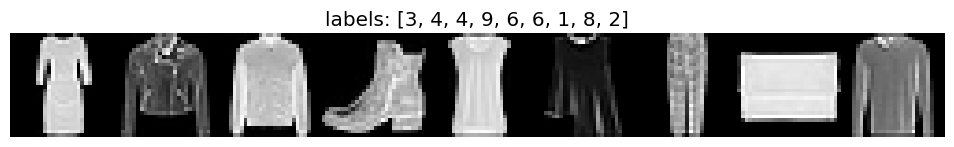

In [23]:
# plot some of the images
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([fashion_train[i][0].reshape(28, 28) for i in range(9)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')
plt.title('labels: ' + str([fashion_train[i][1] for i in range(9)]));

**(a) Can you, as a human, distinguish the different classes? Do you think a neural network should be able to learn to do this as well?<span style="float:right"> (1 point)</span>**

Not really, since 2 and 4 look the same. The neural network will certainly perform better than us.

### Use the DataLoader to create batches

We will use the `DataLoader` from PyTorch (see the [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)) to automatically create random batches of 10 images:

In [31]:
data_loader = torch.utils.data.DataLoader(fashion_train, batch_size=10, shuffle=True)

We will use the data loader to loop over all batches in the dataset.

For each batch, we get `x`, a tensor containing the images, and `y`, containing the label for each image:

In [32]:
for x, y in data_loader:
    print('x.dtype:', x.dtype, 'x.shape:', x.shape)
    print('y.dtype:', y.dtype, '  y.shape:', y.shape)
    # one batch is enough for now
    break

x.dtype: torch.float32 x.shape: torch.Size([10, 784])
y.dtype: torch.int64   y.shape: torch.Size([10])


### Construct a network

We will construct a network that can classify these images.

**(b) Implement a network with the following architecture using `torch.nn.Sequential`:<span style="float:right"> (2 points)</span>**

* Accept flattened inputs: 28 x 28 images mean an input vector with 784 elements.
* Linear hidden layer 1, ReLU activation, output 128 features.
* Linear hidden layer 2, ReLU activation, output 64 features.
* Linear output layer, to 10 classes.
* No final activation function.

In [27]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Linear(784,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,10)
    )
net = build_net()
print(net)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


**(c) Test your network by creating a data loader and computing the output for one batch:<span style="float:right"> (3 points)</span>**

In [36]:
# use a data loader to loop over fashion_train,
# with a batch size of 16, shuffle the dataset
# TODO: construct a DataLoader
data_loader = torch.utils.data.DataLoader(fashion_train, batch_size=16, shuffle=True)

# TODO: construct your network
net = build_net()
for x, y in data_loader:
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    # TODO: run your network to compute the output for x
    output = net(x)
    print('output.shape', output.shape)
    break

x.shape: torch.Size([16, 784])
y.shape: torch.Size([16])
output.shape torch.Size([16, 10])


### Train a network with PyTorch

To train the network, we need a number of components:
* A network, like the one you just defined.
* A [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to loop over the training samples in small batches.
* A loss function, such as the cross-entropy loss. See the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) in the PyTorch documentation.
* An optimizer, such as SGD or Adam: after we use the `backward` function to compute the gradients, the optimizer computes and applies the updates to the weights of the network. See the [optimization algorithms](https://pytorch.org/docs/stable/optim.html) in the PyTorch documentation.

As an example, the code below implements all of these components and runs a single update step of the network.

**(d) Have a look at the code to understand how it works. Then make the following changes:<span style="float:right"> (4 points)</span>**
* Set the batch size to 16
* Use Adam as the optimizer and set the learning rate to 0.01
* For each minibatch, compute the output of the network
* Compute and optimize the cross-entropy loss

In [48]:
# initialize a new instance of the network
net = build_net()

# construct a data loader for the training set
data_loader = torch.utils.data.DataLoader(fashion_train, shuffle=True)

# initialize the SGD optimizer
# we pass the list of parameters of the network
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# TODO: Initialize cross-entropy loss function
loss_function = torch.nn.CrossEntropyLoss()

# repeat for multiple epochs
for epoch in range(20):
    # compute the mean loss and accuracy for this epoch
    loss_sum = 0.0
    accuracy_sum = 0.0
    steps = 0

    # loop over all minibatches in the training set
    for x, y in data_loader:
        # compute the prediction given the input x
        # TODO: compute the output
        output = net(x)

        # compute the loss by comparing with the target output y
        # TODO: use loss_function to compute the loss
        loss = loss_function(output, y)

        # for a one-hot encoding, the output is a score for each class
        # we assign each sample to the class with the highest score
        pred_class = torch.argmax(output, dim=1)
        # compute the mean accuracy
        accuracy = torch.mean((pred_class == y).to(float))

        # reset all gradients to zero before backpropagation
        optimizer.zero_grad()
        # compute the gradient
        loss.backward()
        # use the optimizer to update the parameters
        optimizer.step()

        accuracy_sum += accuracy.detach().cpu().numpy()
        loss_sum += loss.detach().cpu().numpy()
        steps += 1

    # print('y:', y)
    # print('pred_class:', pred_class)
    # print('accuracy:', accuracy)
    print('epoch:', epoch,
          'loss:', loss_sum / steps,
          'accuracy:', accuracy_sum / steps)

epoch: 0 loss: 1.5735962517317383 accuracy: 0.447
epoch: 1 loss: 0.9428682152316905 accuracy: 0.632
epoch: 2 loss: 0.7808724326663069 accuracy: 0.681
epoch: 3 loss: 0.6989707127767179 accuracy: 0.731
epoch: 4 loss: 0.6215324885955124 accuracy: 0.741
epoch: 5 loss: 0.5758765921521745 accuracy: 0.773
epoch: 6 loss: 0.5477686056907951 accuracy: 0.792
epoch: 7 loss: 0.5065359627616212 accuracy: 0.796
epoch: 8 loss: 0.4664672330251796 accuracy: 0.812
epoch: 9 loss: 0.43268525114972045 accuracy: 0.833
epoch: 10 loss: 0.397472510526497 accuracy: 0.85
epoch: 11 loss: 0.3889296165547049 accuracy: 0.844
epoch: 12 loss: 0.34433507083008663 accuracy: 0.872
epoch: 13 loss: 0.364904497504317 accuracy: 0.856
epoch: 14 loss: 0.3272945533191283 accuracy: 0.867
epoch: 15 loss: 0.306109415040231 accuracy: 0.876
epoch: 16 loss: 0.30797522163616087 accuracy: 0.872
epoch: 17 loss: 0.2872132910465036 accuracy: 0.889
epoch: 18 loss: 0.2829910642172052 accuracy: 0.896
epoch: 19 loss: 0.26598691384158824 accura

**(e) Run the optimization for a few epochs. Does the loss go down? Has the training converged?<span style="float:right"> (1 point)</span>**

With 20 epochs and lr=0.01 the loss went down and the training has stopped with accuracy of 90%

**(f) Looking back at the network, we did not include a SoftMax activation function after the last linear layer. But typically you need to use a softmax activation when using cross-entropy loss. Was there a mistake?<span style="float:right"> (1 point)</span>**

Hint: Look at the documentation of the cross-entropy loss function. Is the formula there the same as in the slides?

From the documentation:
"The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general)." \\

$\mathcal{l}(x,y)$ is the same formula as negative log likelihood (sum of logarithms of the likelihood).


**(optional) Why do you think the developers of PyTorch did it this way?**

It is computationally more efficient as compared to calculating softmax before the loss.

## 2.4 Training code for the rest of this assignment

For the rest of this assignment, we will use a slightly more advanced training function. It runs the training loop for multiple epochs, and at the end of each epoch evaluates the network on the validation set.

Feel free to look inside, but keep in mind that some of this code is only needed to generate the plots in this assignment.

In [49]:
def fit(net, train, validation, optimizer, epochs=25, batch_size=10, device=device):
    """
    Train and evaluate a network.
     - net:               the network to optimize
     - train, validation: the training and validation sets
     - optimizer:         the optimizer (such as torch.optim.SGD())
     - epochs:            the number of epochs to train
     - batch_size:        the batch size
     - device:            whether to use a gpu ('cuda') or the cpu ('cpu')
    
    Returns a dictionary of training and validation statistics.
    """

    # move the network parameters to the gpu, if necessary
    net = net.to(device)
    
    # initialize the loss and accuracy history
    history = collections.defaultdict(list)
    epoch_stats, phase = None, None

    # initialize the data loaders
    data_loader = {
        'train':      torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True),
        'validation': torch.utils.data.DataLoader(validation, batch_size=batch_size)
    }

    # measure the length of the experiment
    start_time = time.time()

    # some advanced PyTorch to look inside the network and log the outputs
    # you don't normally need this, but we use it here for our analysis
    def register_measure_hook(idx, module):
        def hook(module, input, output):
            with torch.no_grad():
                # store the mean output values
                epoch_stats['%s %d: %s output mean' % (phase, idx, type(module).__name__)] += \
                    output.mean().detach().cpu().numpy()
                # store the mean absolute output values
                epoch_stats['%s %d: %s output abs mean' % (phase, idx, type(module).__name__)] += \
                    output.abs().mean().detach().cpu().numpy()
                # store the std of the output values
                epoch_stats['%s %d: %s output std' % (phase, idx, type(module).__name__)] += \
                    output.std().detach().cpu().numpy()
        module.register_forward_hook(hook)

    # store the output for all layers in the network
    for layer_idx, layer in enumerate(net):
        register_measure_hook(layer_idx, layer)
    # end of the advanced PyTorch code
    
    for epoch in tqdm.tqdm(range(epochs), desc='Epoch', leave=False):
        # initialize the loss and accuracy for this epoch
        epoch_stats = collections.defaultdict(float)
        epoch_stats['train steps'] = 0
        epoch_stats['validation steps'] = 0
        epoch_outputs = {'train': [], 'validation': []}

        # first train on training data, then evaluate on the validation data
        for phase in ('train', 'validation'):
            # switch between train and validation settings
            net.train(phase == 'train')

            epoch_steps = 0
            epoch_loss = 0
            epoch_accuracy = 0
            
            # loop over all minibatches
            for x, y in data_loader[phase]:
                # move data to gpu, if necessary
                x = x.to(device)
                y = y.to(device)

                # compute the forward pass through the network
                pred_y = net(x)

                # compute the current loss and accuracy
                loss = torch.nn.functional.cross_entropy(pred_y, y)
                pred_class = torch.argmax(pred_y, dim=1)
                accuracy = torch.mean((pred_class == y).to(float))

                # add to epoch loss and accuracy
                epoch_stats['%s loss' % phase] += loss.detach().cpu().numpy()
                epoch_stats['%s accuracy' % phase] += accuracy.detach().cpu().numpy()

                # store outputs for later analysis
                epoch_outputs[phase].append(pred_y.detach().cpu().numpy())

                # only update the network in the training phase
                if phase == 'train':
                    # set gradients to zero
                    optimizer.zero_grad()

                    # backpropagate the gradient through the network
                    loss.backward()

                    # track the gradient and weight of the first layer
                    # (not standard; we only need this for the assignment)
                    epoch_stats['train mean abs grad'] += \
                        torch.mean(torch.abs(net[0].weight.grad)).detach().cpu().numpy()
                    epoch_stats['train mean abs weight'] += \
                        torch.mean(torch.abs(net[0].weight)).detach().cpu().numpy()

                    # update the weights
                    optimizer.step()

                epoch_stats['%s steps' % phase] += 1

            # compute the mean loss and accuracy over all minibatches
            for key in epoch_stats:
                if phase in key and not 'steps' in key:
                    epoch_stats[key] = epoch_stats[key] / epoch_stats['%s steps' % phase]
                    history[key].append(epoch_stats[key])

            # count the number of update steps
            history['%s steps' % phase].append((epoch + 1) * epoch_stats['%s steps' % phase])
            
            # store the outputs
            history['%s outputs' % phase].append(np.concatenate(epoch_outputs[phase]).flatten())

        history['epochs'].append(epoch)
        history['time'].append(time.time() - start_time)

    return history

In [15]:
# helper code to plot our results
class HistoryPlotter:
    def __init__(self, plots, table, rows, cols):
        self.plots = plots
        self.table = table
        self.rows = rows
        self.cols = cols
        self.histories = {}
        self.results = []
        
        self.fig, self.axs = plt.subplots(ncols=cols * len(plots), nrows=rows,
                                          sharex='col', sharey='none',
                                          figsize=(3.5 * cols * len(plots), 3 * rows))
        plt.tight_layout()
        IPython.display.display(self.fig)
        IPython.display.clear_output(wait=True)

    # add the results of an experiment to the plot
    def add(self, title, history, row, col):
        self.histories[title] = history
        self.results.append((title, {key: history[key][-1] for key in self.table}))

        for plot_idx, plot_xy in enumerate(self.plots):
            ax = self.axs[row, col * len(self.plots) + plot_idx]
            for key in plot_xy['y']:
                ax.plot(history[plot_xy['x']], history[key], label=key)
            if 'accuracy' in plot_xy['y'][0]:
                ax.set_ylim([0, 1.01])
            ax.legend()
            ax.set_xlabel(plot_xy['x'])
            ax.set_title(title)
        plt.tight_layout()
        IPython.display.clear_output(wait=True)
        IPython.display.display(self.fig)

    # print a table of the results for all experiments
    def print_table(self):
        df = pd.DataFrame([
            { 'experiment': title, **{key: row[key] for key in self.table} }
            for title, row in self.results
        ])
        IPython.display.display(df)

    def done(self):
        plt.close()
        self.print_table()

## 2.5 Optimization and hyperparameters (10 points)

An important part of training a neural network is hyperparameter optimization: finding good learning rates, minibatch sizes, and other parameters to train an efficient and effective network.

In this part, we will explore some of the most common hyperparameters.

### Learning rate with SGD and Adam

First, we will investigate optimizers and learning rates:
* The choice of optimizer: [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) and especially [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) are common choices.
* The learning rate determines the size of the updates by the optimizer.

Optimizing hyperparameters is often a matter of trial-and-error.

We will run an experiment to train our network with the following settings:
* Optimizer: SGD or Adam
* Learning rate: 0.1, 0.01, 0.001, 0.0001
* Minibatch size: 32
* 150 epochs

For each setting, we will plot:
* The train and validation accuracy
* The train and validation loss

We will also print a table with the results of the final epoch.

**(a) Run the experiment and have a look at the results.**

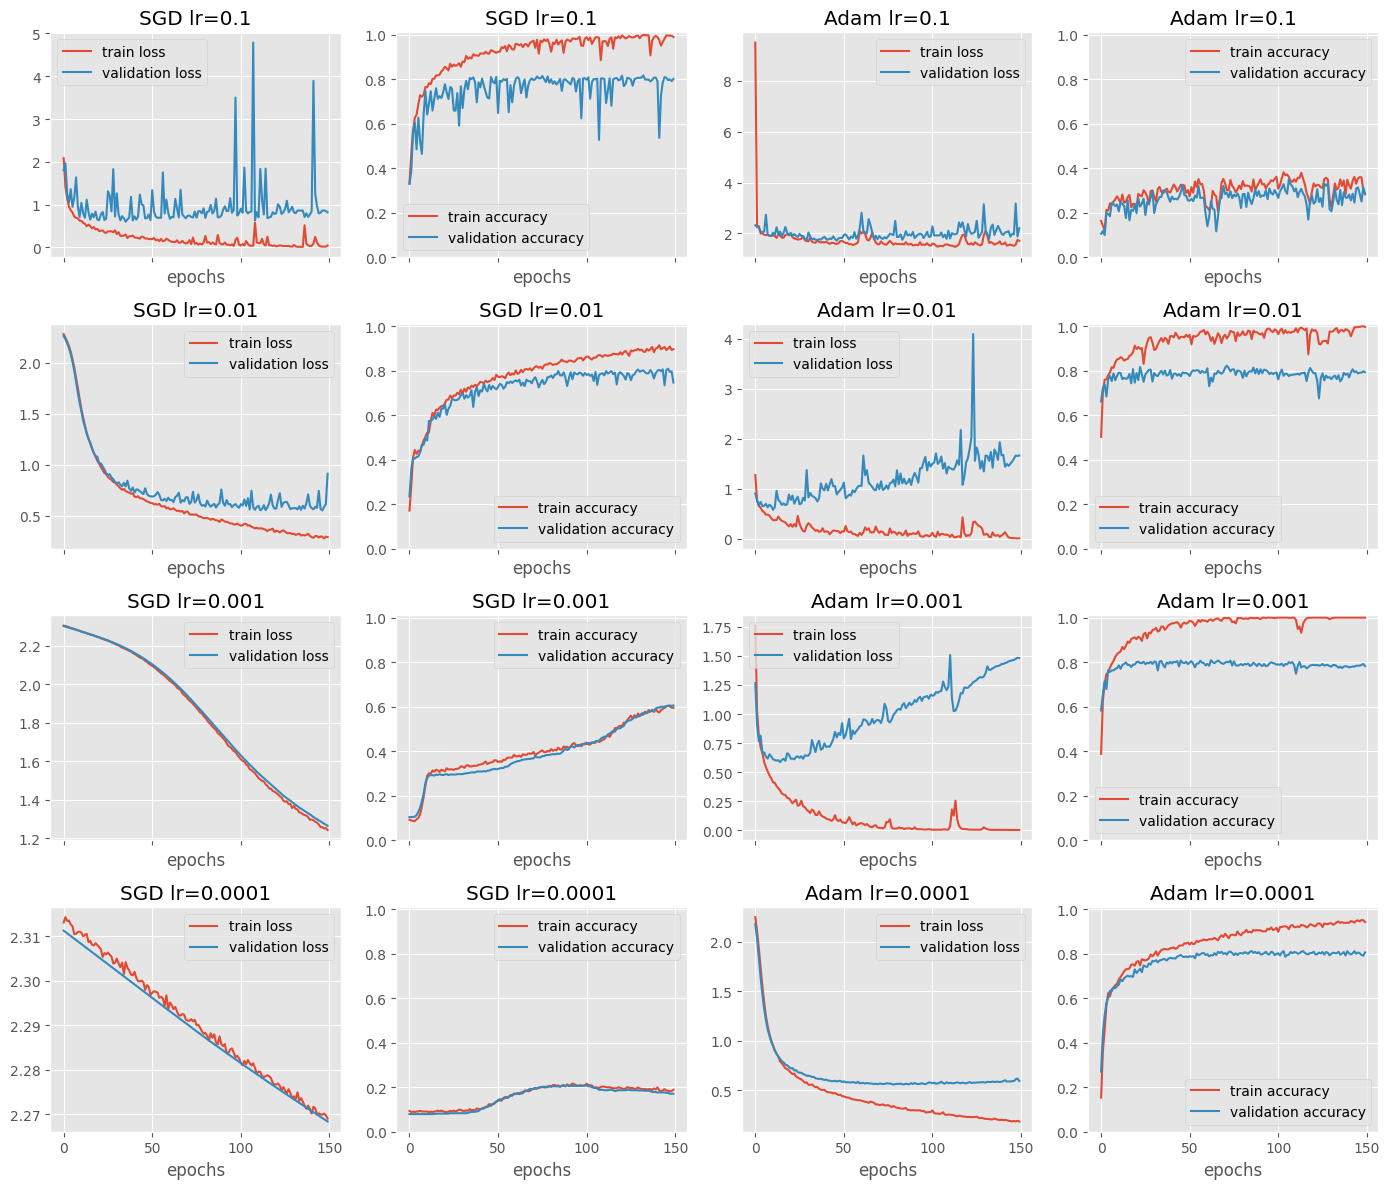

,experiment,train accuracy,validation accuracy
0,SGD lr=0.1,0.989258,0.800781
1,Adam lr=0.1,0.282227,0.285156
2,SGD lr=0.01,0.896484,0.746484
3,Adam lr=0.01,0.996094,0.792969
4,SGD lr=0.001,0.594727,0.605469
5,Adam lr=0.001,1.000000,0.782031
6,SGD lr=0.0001,0.188477,0.170703
7,Adam lr=0.0001,0.942383,0.805469


In [50]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},],
                         table=['train accuracy', 'validation accuracy'],
                         rows=4, cols=2)

epochs = 150
batch_size = 32

for row, lr in enumerate((0.1, 0.01, 0.001, 0.0001)):
    net = build_net()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    history = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter.add('SGD lr=%s' % str(lr), history, row=row, col=0)

    net = build_net()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    history = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter.add('Adam lr=%s' % str(lr), history, row=row, col=1)

plotter.done()

As you can see, not every combination of hyperparameters works equally well.

**(b) Was 150 epochs long enough to train the network with all settings? List the experiments that have/have not yet converged.<span style="float:right"> (2 points)</span>**

*Experiments that have converged to a good result:* SGD 0.1, 0.01 & ADAM: 0.01, 0.001, 0.0001

*Experiments that need more training:* SGD 0.001, 0.0001

*Other experiments:* ADAM 0.001, 0.0001 is overfitting. ADAM 0.01 should be trained for less epochs. ADAM 0.1 converged to a local minimum and is not performing well

**(c) How does the learning rate affect the speed of convergence?<span style="float:right"> (1 point)</span>**

Low learning rate makes convergence really slow while it's convergence is faster in this particular example. But high learning rate has a noisy accuracy curve while lower learning rate is much more smoother. 

**(d) A larger learning rate does not always lead to better or faster training. What happened to Adam with a learning rate of 0.1?<span style="float:right"> (1 point)</span>**

It looks like ADAM 0.1 converged to a local minimum because the accuracy doesn't improve for most of the epochs and loss is stuck at ~2.

**(e) It seems that Adam works reasonably well with learning rates 0.01, 0.001, and 0.0001. Can you explain the difference between the three learning curves, in terms of performance, stability, and speed?<span style="float:right"> (2 points)</span>**

*Final performance:* 0.01 and 0.001 seem to have the same performance while 0.0001 need a bit more time to reach the same performance

*Stability:* 0.01, 0.001 started to overfit midway and their loss is not monotonically decreasing, while 0.0001 seems to be monotonically decreasing and in 150 epoch we don't see the signs of overfitting.

*Speed:* The speed of loss decrease is bigger with larger lr.

### Same accuracy, increasing loss

You may have noticed something interesting in the curves for "Adam lr=0.001": after 10 to 20 epochs, the loss on the validation set starts increasing again, while the accuracy remains the same. How is this possible?

We can find a clue by looking at the output of the network. We will plot the final outputs: the prediction just before the softmax activation function. These values are also called 'logits'.

**(f) Run the code below to generate the plots.**

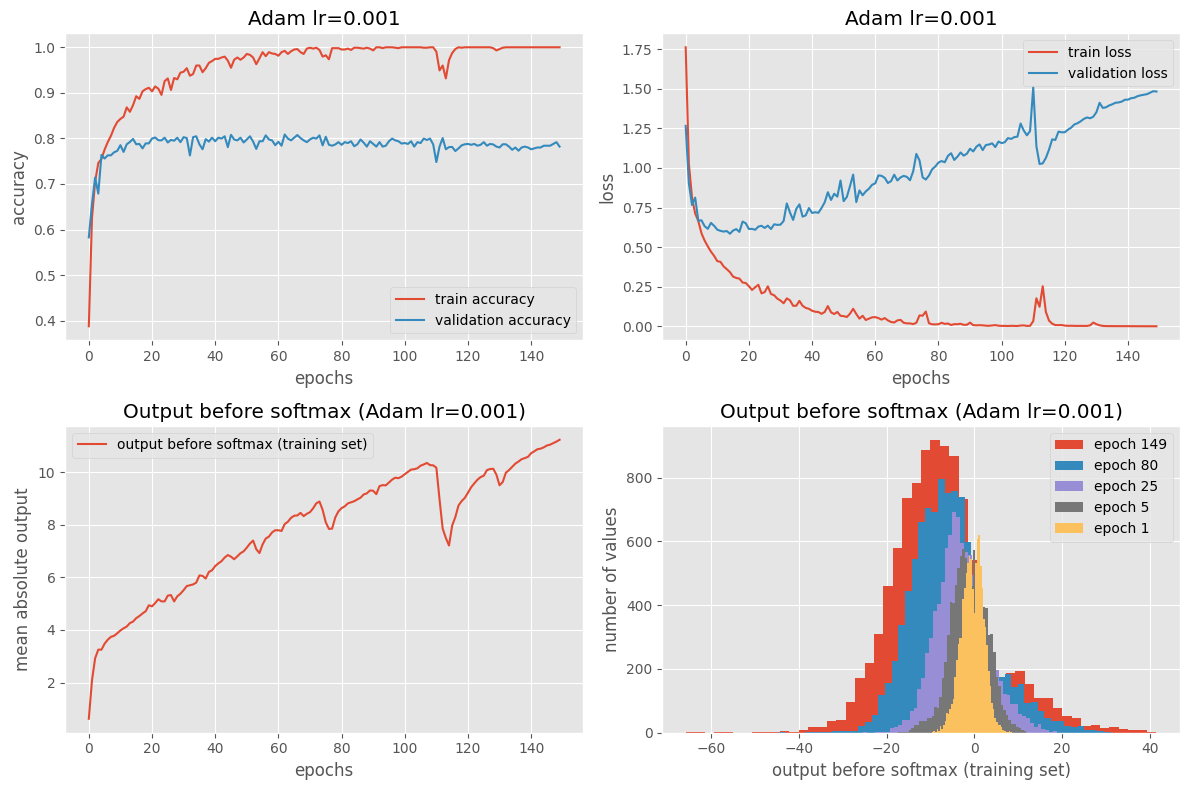

In [51]:
def plot_output_stats():
    fig, axs = plt.subplots(ncols=2, nrows=2,
                                figsize=(6 * 2, 4 * 2))
    # plot train and validation accuracy
    axs[0, 0].plot(plotter.histories['Adam lr=0.001']['epochs'],
                   plotter.histories['Adam lr=0.001']['train accuracy'],
                   label='train accuracy')
    axs[0, 0].plot(plotter.histories['Adam lr=0.001']['epochs'],
                   plotter.histories['Adam lr=0.001']['validation accuracy'],
                   label='validation accuracy')
    axs[0, 0].set_xlabel('epochs')
    axs[0, 0].set_ylabel('accuracy')
    axs[0, 0].set_title('Adam lr=0.001')
    axs[0, 0].legend()

    # plot train and validation loss
    axs[0, 1].plot(plotter.histories['Adam lr=0.001']['epochs'],
                   plotter.histories['Adam lr=0.001']['train loss'],
                   label='train loss')
    axs[0, 1].plot(plotter.histories['Adam lr=0.001']['epochs'],
                   plotter.histories['Adam lr=0.001']['validation loss'],
                   label='validation loss')
    axs[0, 1].set_xlabel('epochs')
    axs[0, 1].set_ylabel('loss')
    axs[0, 1].set_title('Adam lr=0.001')
    axs[0, 1].legend()

    # plot curve of mean absolute output values
    axs[1, 0].plot(plotter.histories['Adam lr=0.001']['epochs'],
                   plotter.histories['Adam lr=0.001']['train 4: Linear output abs mean'],
                   label='output before softmax (training set)')
    axs[1, 0].set_xlabel('epochs')
    axs[1, 0].set_ylabel('mean absolute output')
    axs[1, 0].set_title('Output before softmax (Adam lr=0.001)')
    axs[1, 0].legend()

    # plot distributions of output values
    for epoch in (149, 80, 25, 5, 1):
        axs[1, 1].hist(plotter.histories['Adam lr=0.001']['train outputs'][epoch], bins=50,
                       label='epoch %d' % epoch)
    axs[1, 1].set_xlabel('output before softmax (training set)')
    axs[1, 1].set_ylabel('number of values')
    axs[1, 1].set_title('Output before softmax (Adam lr=0.001)')
    axs[1, 1].legend()

    plt.tight_layout()

plot_output_stats()

Bottom left: the mean of the final outputs for all training images at different epochs.<br>
Bottom right: histograms showing the distribution of the output values at different epochs.

You should now be able to answer this question:

**(g) Why does the accuracy remain stable while the loss keeps increasing?<span style="float:right"> (1 points)</span>**

*Perhaps you can combine these plots with your knowledge of the softmax activation and cross-entropy loss function to explain this curious behaviour.*

Bad predictions are getting worse during the training and they are penalized very hard which gives the larger value for loss.
We can see that the output before softmax at epoch 149 is much more spread out than the output for epoch 1.

### Minibatch size

Another important hyperparameter is the minibatch size. Sometimes your minibatch size is limited by the available memory in your GPU, but you can often choose different values.

We will run an experiment to train our network with different minibatch sizes:
* Minibatch size: 4, 16, 32, 64

We will fix the other hyperparameters to values that worked well in the previous experiment:
* Optimizer: Adam
* Learning rate: 0.0001
* 150 epochs

For each setting, we will plot:
* The train and validation accuracy vs number of epochs
* The train and validation loss vs number of epochs
* The train and validation accuracy vs the number of gradient descent update steps
* The train and validation accuracy vs the training time

We will also print a table with the results of the final epoch.

**(h) Run the experiment and have a look at the results.**

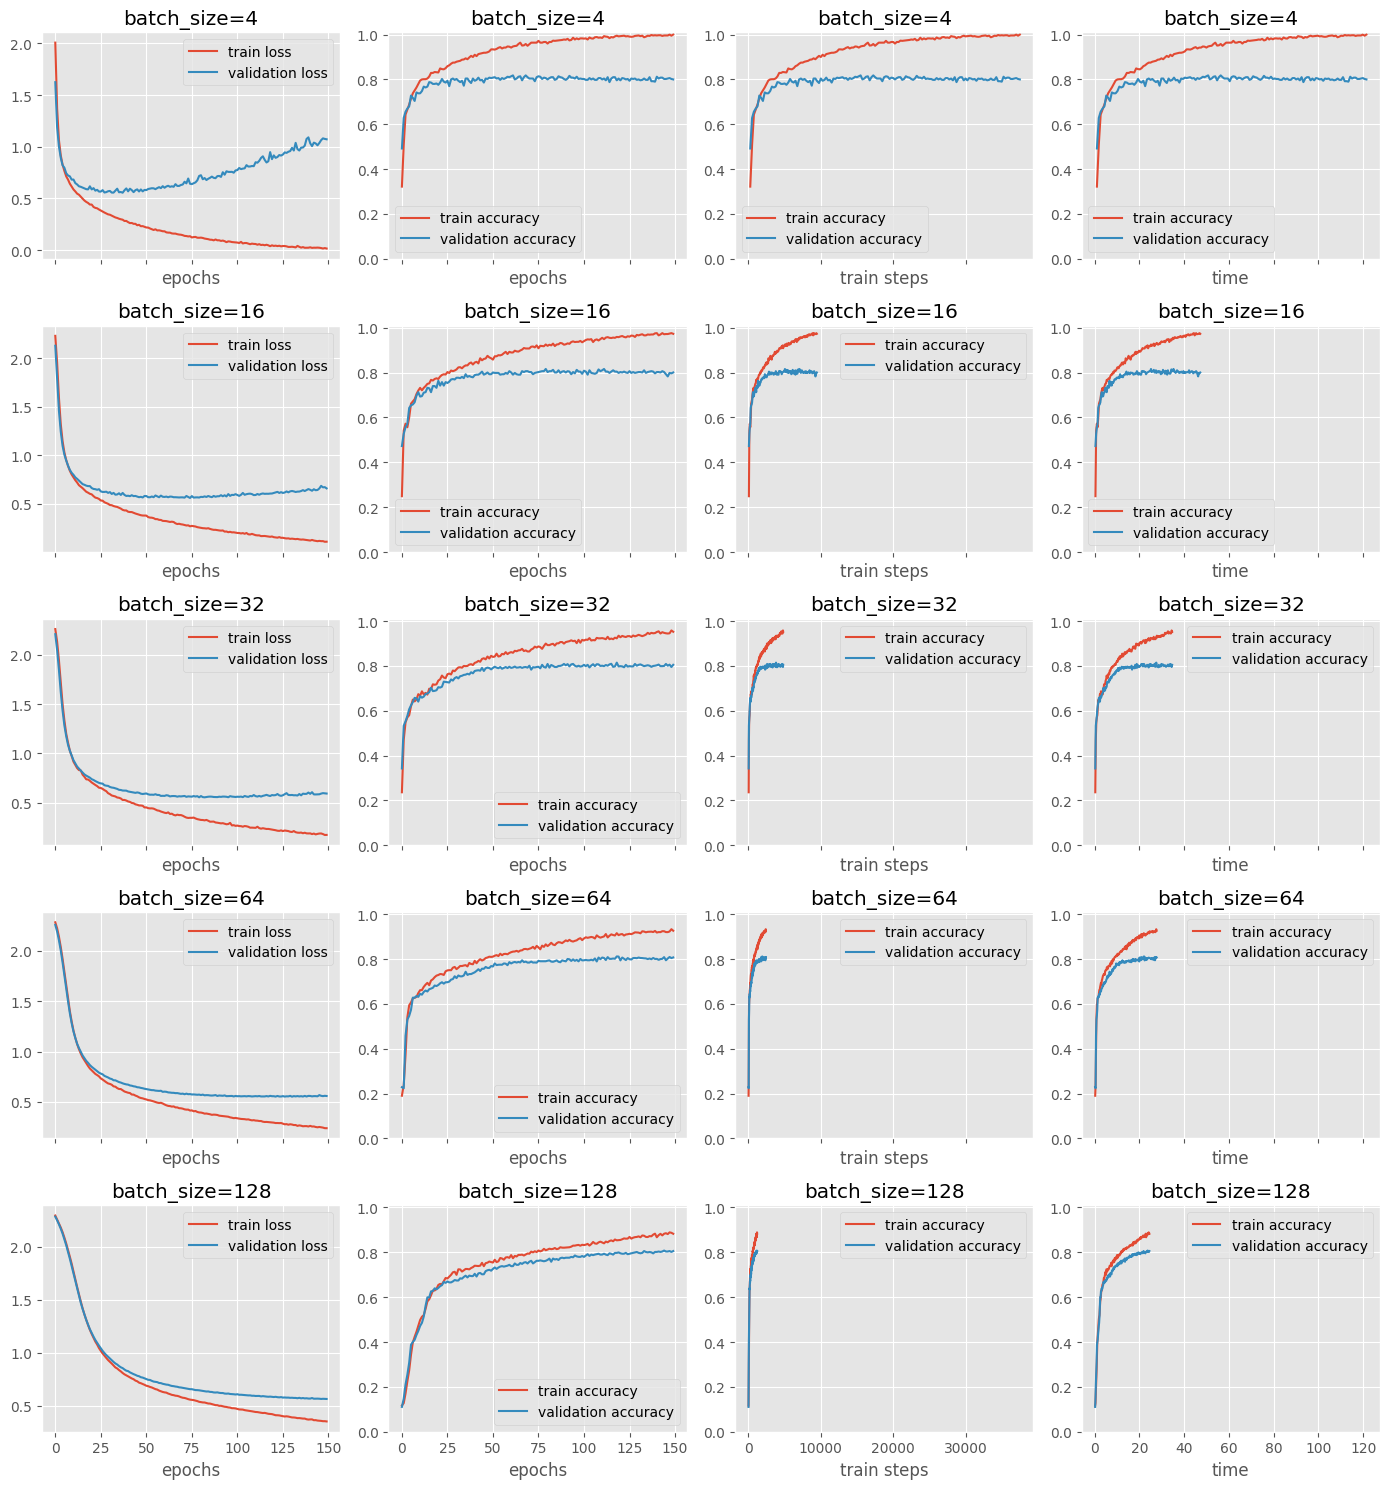

,experiment,train accuracy,validation accuracy,time
0,batch_size=4,1.000000,0.800000,121.472557
1,batch_size=16,0.973214,0.800781,47.167572
2,batch_size=32,0.952148,0.804688,34.602877
3,batch_size=64,0.926562,0.807392,27.671895
4,batch_size=128,0.882812,0.805698,24.431727


In [52]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},
                                {'x': 'train steps', 'y': ['train accuracy', 'validation accuracy']},
                                {'x': 'time', 'y': ['train accuracy', 'validation accuracy']}],
                         table=['train accuracy', 'validation accuracy', 'time'],
                         rows=5, cols=1)

epochs = 150
lr = 0.0001
batch_sizes = [4, 16, 32, 64, 128]

for row, batch_size in enumerate(batch_sizes):
    net = build_net()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    history = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter.add('batch_size=%s' % str(batch_size), history, row=row, col=0)

plotter.done()

**(i) Why is it useful to look at the number of training steps and the training time? How is this visible in the plots?<span style="float:right"> (1 point)</span>**

It's useful because it tells us how efficient learning is. We need more training steps for lower batch size and more time aswell.

**(j) What are the effects of making the minibatches very small?<span style="float:right"> (1 point)</span>**

It takes much longer to train the neural network. Much larger training accuracy. Loss of validation is increasing while accuracy of validation set is staying the same.

**(k) What are the effects of making the minibatches very large?<span style="float:right"> (1 point)</span>**

Faster training time. Lower train accuracy. Same validation accuracy.

## 2.6 Regularization (13 points)

Besides choosing the hyperparameters, we can include other components to improve the training of the model.

In this section, we will experiment with batch normalization, weight decay, and data augmentation.

### Batch normalization

Batch normalization can be implemented with the batch normalization modules from `torch.nn` [(documentation)](https://pytorch.org/docs/stable/nn.html#normalization-layers).

For a network with 1D feature vectors, you can use `torch.nn.BatchNorm1d` [(documentation)](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d).

**(a) Construct a network with batch normalization:<span style="float:right"> (1 point)</span>**

Use the same structure as before, but include batchnorm after the hidden linear layers. So we have:
* A linear layer from 784 to 128 features, followed by batchnorm and a ReLU activation.
* A linear layer from 128 to 64 features, followd by batchnorm and ReLU activation.
* A final linear layer from 64 features to 10 outputs, no activation.

In [54]:
def build_net_bn():
    return torch.nn.Sequential(
        torch.nn.Linear(784,128),
        torch.nn.BatchNorm1d(128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,64),
        torch.nn.BatchNorm1d(64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,10)
    )
net = build_net_bn()
print(net)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
)


We will run an experiment to compare a network without batch normalization with a network with batch normalization.

We will fix the other hyperparameters to values that worked well in the previous experiment:
* Optimizer: Adam
* Learning rate: 0.0001
* Minibatch size: 32
* 150 epochs

**(b) Run the experiment and have a look at the results.**

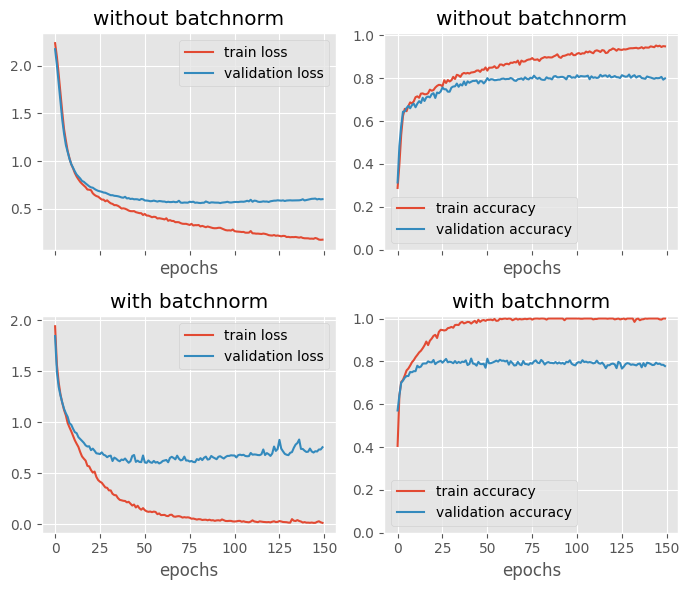

,experiment,train accuracy,validation accuracy
0,without batchnorm,0.949219,0.799609
1,with batchnorm,1.000000,0.778125


In [55]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},],
                         table=['train accuracy', 'validation accuracy'],
                         rows=2, cols=1)

epochs = 150
lr = 0.0001
batch_size = 32

networks = [
    ('without batchnorm', build_net),
    ('with batchnorm',    build_net_bn)
]
histories = {}
for row, (network_name, network_fn) in enumerate(networks):
    net = network_fn()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    history = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter.add(network_name, history, row=row, col=0)
    histories[network_name] = history

plotter.done()

**(c) Does batch normalization improve the performance of the network?<span style="float:right"> (1 point)</span>**

Yes, but only on the training set. The validation accuracy is relatively the same.

**(d) Does batch normalization affect the training or convergence speed?<span style="float:right"> (1 point)</span>**

Yes the speed of convergence is much faster. The training was also faster.

Let us look a bit closer at how batch normalization changes the network.

We will plot some statistics about the values inside the network.

In [56]:
def plot_layer_stats(layers, history):
    fig, axs = plt.subplots(ncols=layers, nrows=2,
                            figsize=(3.5 * layers, 3 * 2))

    for layer in range(layers):
        i = 0
        for stat in ('mean', 'std'):
            for phase in ('train', 'validation'):
                keys = [key for key in history.keys()
                        if '%s %d:' % (phase, layer) in key and 'output %s' % stat in key]
                if len(keys) == 1:
                    key = keys[0]
                    ax = axs[i, layer]
                    ax.plot(history['epochs'], history[key], label='%s output %s' % (phase, stat))
                    ax.set_xlabel('epochs')
                    ax.legend()
                    ax.set_title(key.replace(' output %s' % stat, '').replace(phase, 'layer'))
            i += 1

    plt.tight_layout()

First, we will plot the statistics of the network without batch normalization.

For each layer, the plots show the mean and standard deviation of the output values of that layer:

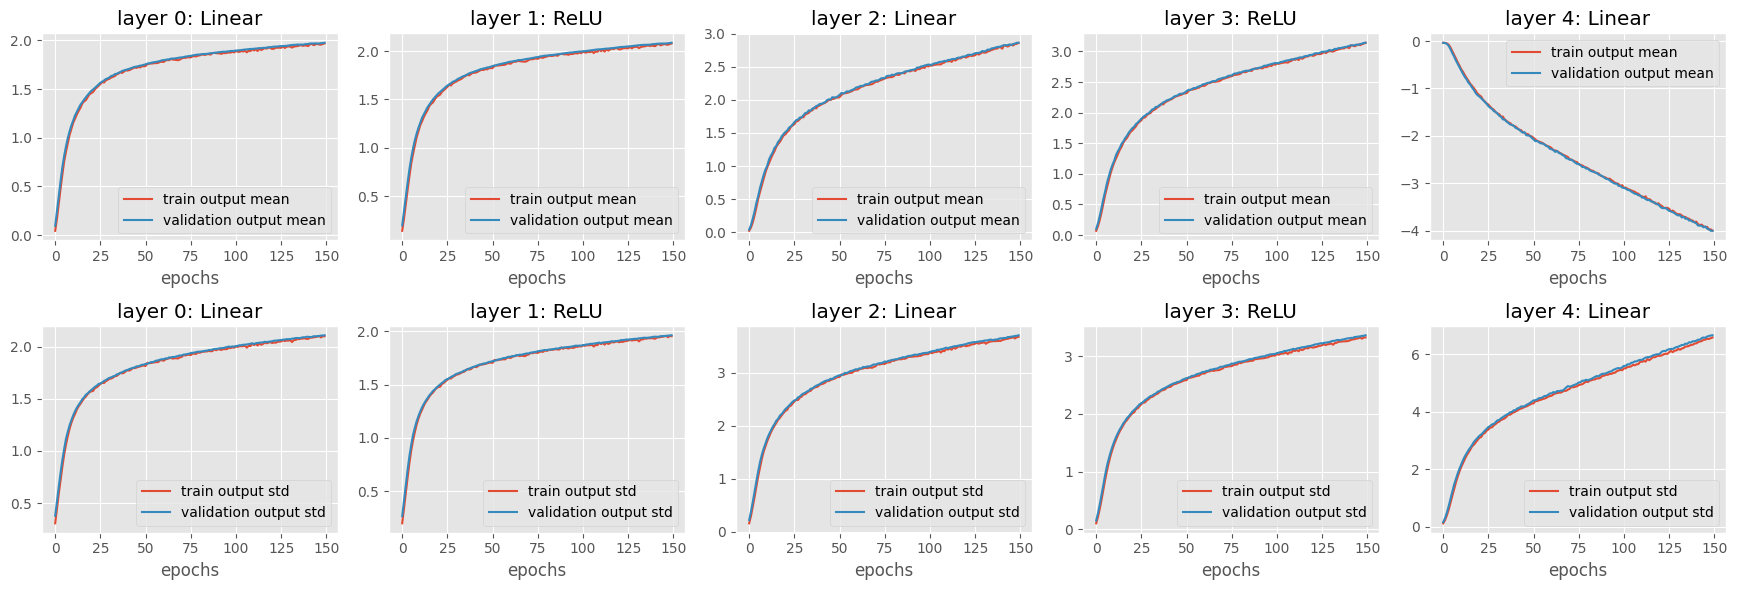

In [57]:
plot_layer_stats(5, histories['without batchnorm'])

We make similar plots for the network with batch normalization: (Note that the number of layers is slightly larger.)

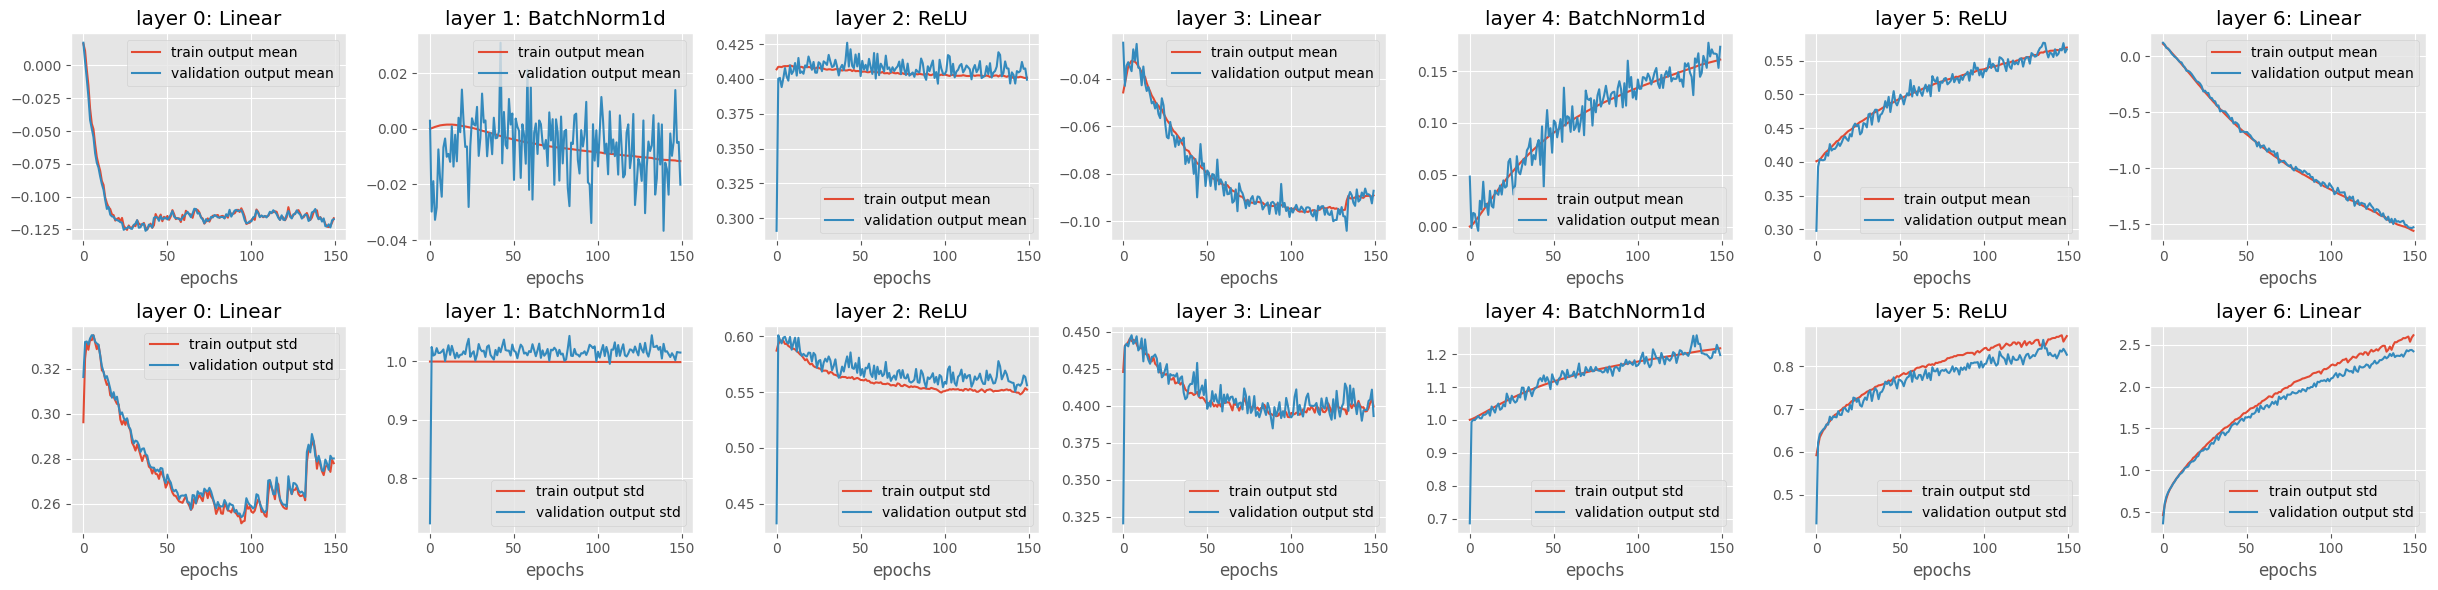

In [58]:
plot_layer_stats(7, histories['with batchnorm'])

**(e) Compare the mean training values in the batch normalization network with those in the network without batch normalization. Can you explain this with how batch normalization works?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(f) Compare the train and validation curves for the batch normalization layers. The training curves are smooth, but the validation curve is noisy. Why does this happen?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(g) Batch normalization is supposed to normalize the values to $\mu = 0$ and $\sigma = 1$, but in layer 4, the mean and standard deviation are steadily increasing over time. Why and how does this happen?<span style="float:right"> (1 point)</span>**

TODO Your answer here.

### Weight decay

The training can also be regularized using weight decay. This option is built-in in many of the PyTorch optimizers [(documentation)](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam).

We will set up an experiment to investigate how this affects the training of the model.

We use the good settings from before:
* Optimizer: Adam
* Learning rate: 0.0001
* Minibatch size: 32
* 150 epochs

and apply L2 weight decay with a factor 0, 0.0001, 0.001, 0.01, or 0.1.

**(h) Complete the code below and run the experiment. <span style="float:right"> (1 point)</span>**

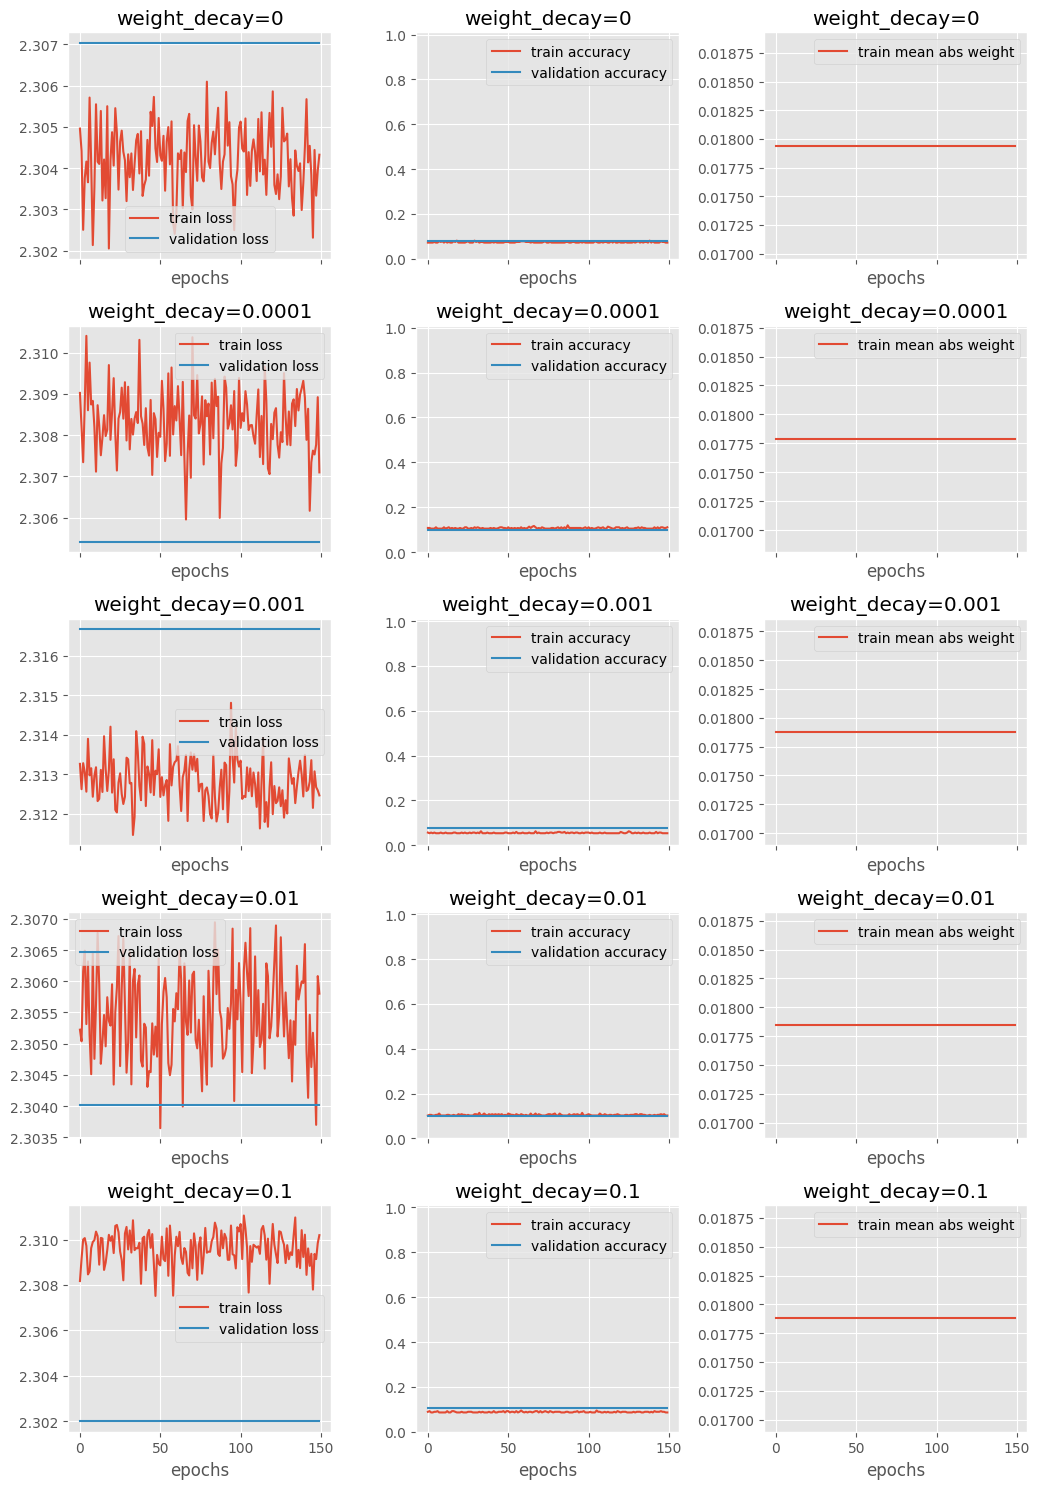

,experiment,train accuracy,validation accuracy,train mean abs weight
0,weight_decay=0,0.072266,0.080859,0.017942
1,weight_decay=0.0001,0.110352,0.096875,0.017789
2,weight_decay=0.001,0.053711,0.075391,0.017877
3,weight_decay=0.01,0.102539,0.099219,0.017844
4,weight_decay=0.1,0.085938,0.103906,0.017877


In [59]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},
                                {'x': 'epochs', 'y': ['train mean abs weight']},],
                         table=['train accuracy', 'validation accuracy', 'train mean abs weight'],
                         rows=5, cols=1)

epochs = 150
lr = 0.0001
batch_size = 32
weight_decays = [0, 0.0001, 0.001, 0.01, 0.1]

for row, weight_decay in enumerate(weight_decays):
    net = build_net()
    # TODO: Set up optimizer with the given weight_decay
    optmizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    history = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter.add('weight_decay=%s' % str(weight_decay), history, row=row, col=0)

plotter.done()

**(i) How can you observe the amount of overfitting in the plots? <span style="float:right"> (1 point)</span>**

TODO Your answer here.

**(j) How does weight decay affect the performance of the model in the above experiments? Give an explanation in terms of the amount of overfitting. <span style="float:right"> (1 point)</span>**

TODO Your answer here.

### Data augmentation

Finally, we will look at data augmentation.

We will run experiments with three types of data augmentation:
* Adding random noise to the pixels, taken from a normal distribution $\mathcal{N}(0, \sigma)$ with $\sigma$ = 0, 0.01, 0.1, or 0.2.
* Flipping the image horizontally.
* Shifting the image up, down, left, or right by one pixel.

We create a new dataset class that generates noisy images and use this instead of our normal training set.

In [ ]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, ds, noise_sigma=0, flip_horizontal=False, shift=False):
        self.ds = ds
        self.noise_sigma = noise_sigma
        self.flip_horizontal = flip_horizontal
        self.shift = shift

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        x, y = self.ds[idx]
        # add random noise
        x = x + self.noise_sigma * torch.randn(x.shape)
        # flip the pixels horizontally with probability 0.5
        if self.flip_horizontal and torch.rand(1) > 0.5:
            x = torch.flip(x.reshape(28, 28), dims=(1,)).flatten()
        # shift the image by one pixel in the horizontal or vertical directions
        if self.shift:
            x = x.reshape(28, 28)
            # shift max one pixel
            shifts = [*torch.randint(-1, 2, (2,)).numpy()]
            x = torch.roll(x, shifts=shifts, dims=(0, 1))
            x = x.flatten()
        return x, y

We set up an experiment to see if data augmentation improves our results. We use combinations of the three augmentations: noise, flipping, and shifting.

We will train for 250 epochs.

We keep the other settings as before:
* Optimizer: Adam
* Learning rate: 0.0001
* Minibatch size: 32

**(k) Run the experiment and have a look at the results.**

In [ ]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},],
                         table=['train accuracy', 'validation accuracy', 'time'],
                         rows=8, cols=2)

epochs = 250
lr = 0.0001
batch_size = 32

for row, noise_sigma in enumerate((0, 0.01, 0.1, 0.2)):
    for row2, shift in enumerate([False,True]):
        for col, flip_horizontal in enumerate([False,True]):
            noisy_fashion_train = NoisyDataset(fashion_train, noise_sigma, flip_horizontal=flip_horizontal, shift=shift)
            net = build_net()
            optimizer = torch.optim.Adam(net.parameters(), lr=lr)
            history = fit(net, noisy_fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
            label = ('noise=%s' % str(noise_sigma)) + \
                    (', shift' if shift else '') + \
                    (', flip horizontal' if flip_horizontal else '')
            plotter.add(label, history, row=row*2+row2, col=col)

plotter.done()

**(l) How does data augmentation affect overfitting in the above experiment? Discuss each of the augmentation types.<span style="float:right"> (3 points)</span>**

*Adding noise:*
TODO Your answer here.

*Horizontal flips:*
TODO Your answer here.

*Shifting:*
TODO Your answer here.

**(m) Why do we have to train the networks with data augmentation a bit longer than networks without data augmentation?<span style="float:right"> (1 points)</span>**

TODO: Your answer here.

## 2.7 Network architecture (5 points)

An often overlooked hyperparameter is the architecture of the neural network itself. Here you can think about the width (the size of each hidden layer) or the depth (the number of layers).

**(a) Copy the `build_net` function from 2.3b and change it to take a parameter for the width of the first hidden layer. <span style="float:right"> (1 point)</span>**

The second hidden layer should have half that width, so the network we have been using so far has `width=128`.

Hint: `a // b` is the Python notation for integer division rounding down.

In [ ]:
def build_net(width = 128):
    # TODO: construct and return the network
    return None

**(b) Set up an experiment to see how the size of the network affects our results. <span style="float:right"> (1 point)</span>**

We keep the other settings as before:
* Optimizer: Adam
* Epochs: 150
* Learning rate: 0.0001
* Minibatch size: 32
* Widths: 16, 32, 64, 128, 256, 512

In [ ]:
plotter = HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                                {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},],
                         table=['train accuracy', 'validation accuracy', 'time'],
                         rows=6, cols=1)

epochs = 150
lr = 0.0001
batch_size = 32
network_widths = [16, 32, 64, 128, 256, 512]

for row, width in enumerate(network_widths):
    # TODO: Run optimizer for a network of width width, add to plotter

plotter.done()

**(c) For what network sizes do you observe underfitting? <span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(d) Do you see overfitting for the largest networks? How can you see this from the plots? <span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(e) How many parameters are there in a network with width 128? How does that compare to the number of training samples?<span style="float:right"> (1 point)</span>**

You don't have to give an exact value, as long as you are in the right order of magnitude it is okay.

(Feel free to write some python code to do computations.)

TODO: Your answer here.

## 2.8 Discussion (3 points)

**(a) Several of the experiments have included a baseline with exactly the same hyperparameters (batch_size=32, weight_decay=0, network_size=128). Are the results exactly the same? What does this tell you about comparing results for picking the best hyperparameters?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(b) Throughout this assignment we have used a validation set of 500 samples for selecting hyperparameters. Do you think that you will see the same results on an independent test set? Would the best results be obtained with the hyperparameters that are optimal on the validation set? <span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 44 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version d4d27c6 / 2023-09-08</span>